# CASA0007 - Quantitative Methods Group Project
## Group 25

In [18]:
#Reading in libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

  Preparing metadata (setup.py) ... done
  Created wheel for fitter: filename=fitter-1.5.1-py3-none-any.whl size=25596 sha256=4a1de6436b3ca3ab880e0aa0ff0b5a99538ba60af950537390bcb8e50b6f933d
  Stored in directory: /home/jovyan/.cache/pip/wheels/b6/54/95/86a0ae87e8aa67a18b6353ec719a161db02401df3ff6f7f07d
Successfully built fitter


## 1. Context of the data

### 1.0. Aggregation Level - Zach

Data is aggregated to the Output Area (OA) Level. This being the smallest level of aggregation that the census data is released on by the ONS (Office of National Statistics). 
- Each OA contains between 40 and 250 households, leading to an estimated population of between 100 and 625. 
- **Limitation** of aggregation level: OAs change between each census (10 year lifecycle) due to variation in population density, meaning data cannot always be compared between census' easily. 




**UK Administrative Units**
1. Output Areas (OAs)
2. Lower Super Output Areas (LSOAs)
3. Middle layer Super Output Areas (MSOAs)
4. Boroughs/ Local Administrative Unit (LAD)


### 1.1. Cycle to work - Joe
This dataset is from the 2011 Census. Results are based off a Census question that classifies usual residents aged 16 to 74 in England and Wales by their method of travel to work, disaggregated by Census Output Area (OA). The estimates are as at census day, 27 March 2011 (single time snapshot). The dataset can be found [here](https://www.nomisweb.co.uk/census/2011/qs701ew).

### 1.2. Deprivation - Yubin

The dataset is based on the 2011 Census provided by Office for National Statistics (ONS), classified households in England and Wales through four domains of deprivation: Employment, Education, Health and disability, and Household overcrowding. It is a nationally representative data and the estimates are as at census day, 27 March 2011.

A household would be defined as deprived if they meet one or more of the following conditions:
1. Employment: Any member of a household, who is not a full-time student, is either unemployed or long-term sick.
2. Education: No person in the household has at least Level 2 education (see highest level of qualification), and no person aged 16 to 18 is a full-time student.
3. Health and disability: Any person in the household has general health that is 'bad' or 'very bad' or has a long-term health problem.
4. Housing: The household's accommodation is either overcrowded, with an occupancy rating -1 or less, or is in a shared dwelling, or has no central heating.


### 1.3. Air Quality - Zach [[Data](https://data.london.gov.uk/dataset/pm2-5-map-and-exposure-data)]

This dataset identifies modelled PM<sub>2.5 </sub>(particulate matter of diameter 2.5 micrometers or less) across London's Output Areas. 
- Modelled by Tfl (Transport for London) and GLA (Greater London Authority)

Increased exposure to high levels of partculate matter have been linked to increased rate of cardiovascular and respiratory disease (Liu, 2019). 

This data is being considered due to the assumption that emission levels infulence the decision making process of commuters. This emissions data could be used as a proxy for volume of motor vehicles, or considered as a variable having an impact by itself on decision making.



| Variable| Unit | Description |
| --- | --- | --- |
| PM<sub>2.5 </sub> | µg/m<sup>3 </sup>| Modelled concentration of particulate matter with diameter or 2.5 micrometers or less. | 


**Limitations:**
- Assuming causality of air quality and commuting choice would be incorrect. It is possible that air pollution is low due to choice of pollution. Suggesting an inverse relationship to that initally proposed. 


### 1.4. Cycle Sharing

## 2. Description of data fields/ variables

### 2.1. Cycle to work - Joe
* Read in the data

In [7]:
cycletowork = pd.read_csv('data/cycleing_to_work_oa.csv')
cycletowork.columns

Index(['date', 'geography', 'geography code', 'Rural Urban',
       'Method of Travel to Work: All categories: Method of travel to work; measures: Value',
       'Method of Travel to Work: Work mainly at or from home; measures: Value',
       'Method of Travel to Work: Underground, metro, light rail, tram; measures: Value',
       'Method of Travel to Work: Train; measures: Value',
       'Method of Travel to Work: Bus, minibus or coach; measures: Value',
       'Method of Travel to Work: Taxi; measures: Value',
       'Method of Travel to Work: Motorcycle, scooter or moped; measures: Value',
       'Method of Travel to Work: Driving a car or van; measures: Value',
       'Method of Travel to Work: Passenger in a car or van; measures: Value',
       'Method of Travel to Work: Bicycle; measures: Value',
       'Method of Travel to Work: On foot; measures: Value',
       'Method of Travel to Work: Other method of travel to work; measures: Value',
       'Method of Travel to Work: Not in 

* Drop unnecessary columns

In [8]:
cycletowork = cycletowork[['date',
                           'geography code',
                           'Method of Travel to Work: Bicycle; measures: Value',
                           'Method of Travel to Work: All categories: Method of travel to work; measures: Value']]
cycletowork.columns

Index(['date', 'geography code',
       'Method of Travel to Work: Bicycle; measures: Value',
       'Method of Travel to Work: All categories: Method of travel to work; measures: Value'],
      dtype='object')

In [33]:
cycletowork.dtypes

date                                                                                    int64
geography code                                                                         object
Method of Travel to Work: Bicycle; measures: Value                                      int64
Method of Travel to Work: All categories: Method of travel to work; measures: Value     int64
dtype: object

In [34]:
cycletowork.head(5)

,date,geography code,Method of Travel to Work: Bicycle; measures: Value,Method of Travel to Work: All categories: Method of travel to work; measures: Value
0,2011,E00004482,34,235
1,2011,E00004497,12,192
2,2011,E00004498,13,235
3,2011,E00004502,6,187
4,2011,E00004505,12,213


The relevant fields for our analysis are as follows:  
| Field name  | Data type  | Description  |
|---|---|---|
| Date  | Integer  | Year data  was collected (2011 census)  |
| Geography code  | String  | Census Output Area unique identifier. The string format can be used to filter OAs by UK region.  |
| Method of Travel to Work: Bicycle  | Integer  | Count of residents aged 16 to 74 who used a bicycle as their method of travel to work on the Census date  |
| Method of Travel to Work: All categories  | Integer  | Total count of residents aged 16 to 74 who provided a response for method of travel to work on the census date  |

### 2.2. Deprivation

In [116]:
deprivation = pd.read_csv('https://github.com/ZacharyP-E/qm_group25/blob/fcde288de69abe4f7dd76d6b156ebd82201d619a/data/deprivation_oa.csv')
deprivation.head(10)

,date,geography,geography code,Rural Urban,Household Deprivation: All categories: Classification of household deprivation; measures: Value,Household Deprivation: Household is not deprived in any dimension; measures: Value,Household Deprivation: Household is deprived in 1 dimension; measures: Value,Household Deprivation: Household is deprived in 2 dimensions; measures: Value,Household Deprivation: Household is deprived in 3 dimensions; measures: Value,Household Deprivation: Household is deprived in 4 dimensions; measures: Value
0,2011,E00004482,E00004482,Total,121,71,30,16,4,0
1,2011,E00004497,E00004497,Total,117,32,30,33,17,5
2,2011,E00004498,E00004498,Total,145,43,50,36,15,1
3,2011,E00004502,E00004502,Total,120,30,39,29,20,2
4,2011,E00004505,E00004505,Total,124,50,26,28,18,2
5,2011,E00004481,E00004481,Total,133,39,43,37,14,0
6,2011,E00004493,E00004493,Total,118,39,54,14,6,5
7,2011,E00004500,E00004500,Total,131,37,58,26,9,1
8,2011,E00004501,E00004501,Total,76,28,25,16,6,1
9,2011,E00004503,E00004503,Total,132,32,52,35,12,1


### 2.3. Air Quality - Zach

In [4]:
#Reading in data
aq_df = pd.read_csv("data/OA2_PM25_2013.csv")

In [6]:
#Identifying usable columns
aq_df.head()

,OA11CD,LAD11NM,PM252013me
0,E00024024,Westminster,17.953073
1,E00023833,Westminster,18.183844
2,E00023830,Westminster,18.732058
3,E00023831,Westminster,17.909357
4,E00024021,Westminster,17.185809


Columns:
- OA11CD refers to the unique Output Area code, allowing merging with other data as an explanatory variable. 
- LAD11NM refers to the Borough (three levels of aggregation above OAs) that the OA is within. Boroughs are local administrative units that resources are allocatacted to, which are then distributed across the OAs dependnent on needs. 

### 2.4. Cycle Sharing

## 3. Summary statistic fields

### 3.1. Cycle to Work - Joe

### 3.2. Deprivation - Yubin

### 3.3. Air Quality - Zach

In [11]:
aq_df.describe()

,PM252013me
count,25946.000000
mean,16.001274
std,0.788874
min,14.283266
25%,15.417784
50%,15.873302
75%,16.464573
max,21.100099


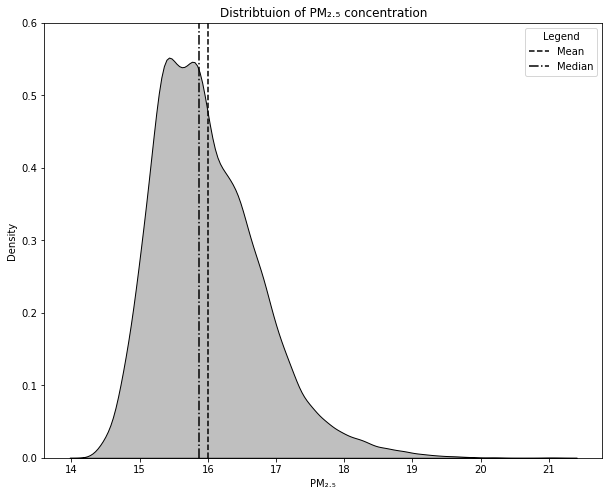

In [48]:
fig, ax = plt.subplots(1, figsize=(10,8))
sns.kdeplot(aq_df["PM252013me"], ax=ax, color="black", shade=True)
plt.xlabel("PM\u2082.\u2085")
plt.vlines(aq_df["PM252013me"].mean(), 0, 0.65, linestyle="--", color="black", label="Mean")
plt.vlines(aq_df["PM252013me"].median(), 0, 0.65, linestyle="-.", color="black", label="Median")
plt.legend(title="Legend")
plt.title("Distribtuion of PM\u2082.\u2085 concentration")
plt.ylim(0,0.60)
plt.savefig("figures/aq_kdeplot.png", dpi=300, facecolor="white", bbox_inches="tight")
plt.show()

Data appears to be positvely skewed. Would applying a log fix it?

In [89]:
aq_df["dif_mean"] = aq_df["PM252013me"] - aq_df["PM252013me"].mean()

In [96]:
aq_df["dif_mean_and_std"] = aq_df["dif_mean"] / aq_df["PM252013me"].std()

In [93]:
#Applying a log function to the data
aq_df["PMlog"] = np.log(aq_df["PM252013me"])

None of which normalise the data

### 3.4. Cycle Sharing - 

## 4. Appropriate plots to communicate distribution

### 4.0. Merging of data - Zach

In [52]:
#ZPE importing here as importing from link didn't work for me
deprivation = pd.read_csv("data/deprivation_oa.csv")

In [65]:
#Merging the cycle to work data to deprivation data to form a main dataframe
df = cycletowork.merge(deprivation, how="left", on="geography code")

In [67]:
#Adding the air quality data to the main dataframe
df = df.merge(aq_df, how = "left", left_on="geography code", right_on="OA11CD")

In [74]:
#Identifying any NA values
df.isna().sum().reset_index().rename(columns={"index":"Column Name", 0:"Quantity of NAs"})

,Column Name,Quantity of NAs
0,date_x,0
1,geography code,0
2,Method of Travel to Work: Bicycle; measures: V...,0
3,Method of Travel to Work: All categories: Meth...,0
4,date_y,0
5,geography,0
6,Rural Urban,0
7,Household Deprivation: All categories: Classif...,0
8,Household Deprivation: Household is not depriv...,0
9,Household Deprivation: Household is deprived i...,0


No NA values present within the dataset

In [77]:
#Removing any duplicated rows.
df = df.drop_duplicates(keep="first")

### 4.1. Basic Plotting

#### 4.1.1 Cycle to work and Deprivation

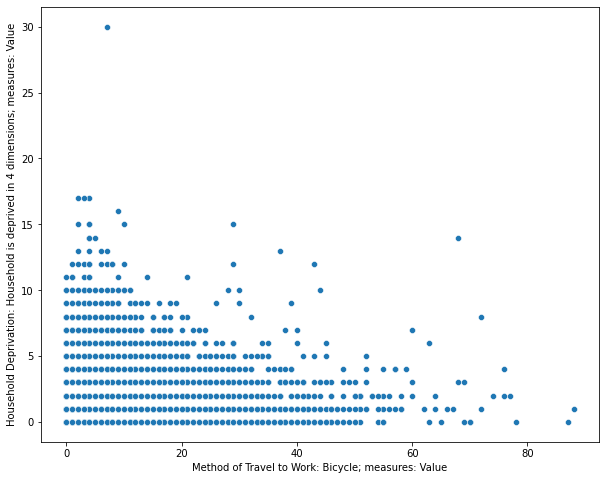

In [113]:
fig, ax = plt.subplots(1, figsize = (10,8))
sns.scatterplot(data = df, x="Method of Travel to Work: Bicycle; measures: Value", 
            y="Household Deprivation: Household is deprived in 4 dimensions; measures: Value", ax=ax)
                       
plt.show()

Hard to identify relationship? Might be difficult to plot a regression line.

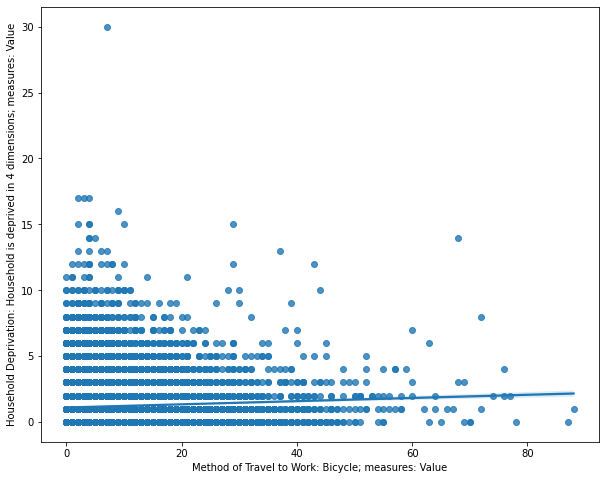

In [115]:
fig, ax = plt.subplots(1, figsize = (10,8))
sns.regplot(data = df, x="Method of Travel to Work: Bicycle; measures: Value", 
            y="Household Deprivation: Household is deprived in 4 dimensions; measures: Value", ax=ax)
                       
plt.show()

Regression plot reveals no majour relationship. Suggesting it is unlikely that deprevation of 

#### 4.1.2 Cycle to work and Pollution

## drop_duplicatesopriate plots to illustrate relationship between key fields

# References

Liu, C., Chen, R., Sera, F., Vicedo-Cabrera, A.M., Guo, Y., Tong, S., Coelho, M.S., Saldiva, P.H., Lavigne, E., Matus, P. and Valdes Ortega, N., 2019. Ambient particulate air pollution and daily mortality in 652 cities. New England Journal of Medicine, 381(8), pp.705-715.